# 🧭 Тестирование YOLO v3 — алгоритма обнаружения объектов
* Использование библиотеки **'dnn'** OpenCV для загрузки модели нейронной сети из файла конфигурации.

* Использование весов, обученных на наборе данных COCO из 80 классов.


# 🎓 Сопутствующий курс по задачам классификации

**Проектируйте**, **обучайте** и **тестируйте** глубокую CNN для классификации изображений.

**Присоединяйтесь** к курсу и наслаждайтесь новыми возможностями для приобретения навыков глубокого обучения:


[https://www.udemy.com/course/convolutional-neural-networks-for-image-classification/](https://www.udemy.com/course/convolutional-neural-networks-for-image-classification/?referralCode=12EE0D74A405BF4DDE9B)


![](https://github.com/sichkar-valentyn/1-million-images-for-Traffic-Signs-Classification-tasks/blob/main/images/slideshow_classification.gif?raw=true)

# 📥 Импорт необходимых библиотек

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time


# 📂 Загрузка меток классов COCO из файла

In [ ]:
# Открытие файла, чтение, удаление пробелов и разбиение по '\n', что, в свою очередь, создает список
labels = open('../input/yolo-coco-data/coco.names').read().strip().split('\n')  # список имен


# print(labels)


In [ ]:
# Определение путей к весам и файлу конфигурации с моделью нейронной сети
weights_path = '../input/yolo-coco-data/yolov3.weights'
configuration_path = '../input/yolo-coco-data/yolov3.cfg'

# Установка минимальной вероятности для устранения слабых прогнозов
probability_minimum = 0.5

# Установка порога для немаксимального подавления
threshold = 0.3


# 🗂️ Загрузка обученного детектора объектов YOLO с помощью библиотеки dnn из OpenCV

In [ ]:
network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)

# Получение названий всех слоев
layers_names_all = network.getLayerNames()  # список названий слоев


# print(layers_names_all)


In [ ]:
# Получение только тех имен выходных слоев, которые нам нужны из алгоритма YOLO
layers_names_output = [layers_names_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]  # список названий слоев


print(layers_names_output)  # ['yolo_82', 'yolo_94', 'yolo_106']


['yolo_82', 'yolo_94', 'yolo_106']


# 🗀Загрузка входного изображения из файла

In [ ]:
# Наше изображение изначально имеет формат RGB
# Но теперь мы открываем его в формате BGR, так как функция «cv2.imread» открывает его.
image_input = cv2.imread('../input/images-for-testing/cat2.jpg')

# Получаем форму изображения
image_input_shape = image_input.shape


print(image_input_shape)  # tuple of (917, 1222, 3)


(917, 1222, 3)


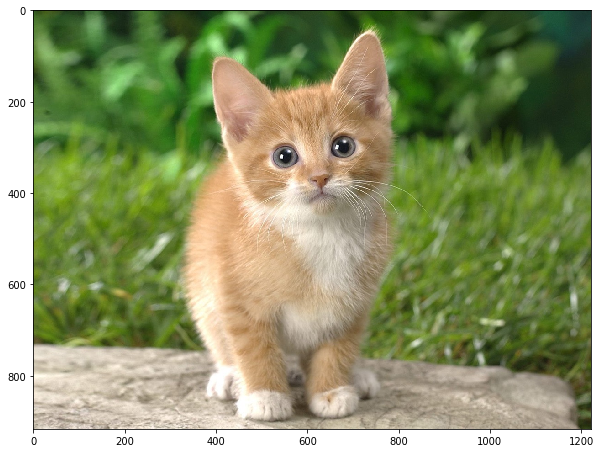

In [ ]:
# Показываем изображение RGB, но предварительно конвертируем его из формата BGR
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()


# 💡 Получение blob из входного изображения

In [ ]:
# Функция 'cv2.dnn.blobFromImage' возвращает 4-мерный большой объект.
# из входного изображения после вычитания среднего, нормализации и замены каналов RB
# Полученная форма имеет количество изображений, количество каналов, ширину и высоту.
# E.G.: blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size, mean, swapRB=True)
# Link: https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/
blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB=True, crop=False)


print(image_input.shape)  # (917, 1222, 3)
print(blob.shape)  # (1, 3, 416, 416)


(917, 1222, 3)
(1, 3, 416, 416)


(416, 416, 3)


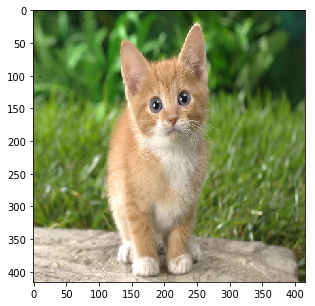

In [ ]:
# Нарезка объекта и транспонирование, чтобы каналы располагались в конце
blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
print(blob_to_show.shape)  # (416, 416, 3)

# Showing 'blob_to_show'
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(blob_to_show)
plt.show()

# ➰ Реализация прямого прохода с нашим BLOB-объектом и только через выходные слои.

In [ ]:
# Одновременно вычисляем необходимое время для прохода вперед
network.setInput(blob)  # установка blob в качестве входных данных в сеть
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

# Показаны затраченное время для прохода вперед
print('YOLO v3 took {:.5f} seconds'.format(end - start))


YOLO v3 took 0.99887 seconds


In [ ]:
print(type(output_from_network))  # <class 'list'>
print(type(output_from_network[0]))  # <class 'numpy.ndarray'>

<class 'list'>
<class 'numpy.ndarray'>


# 🌈 Цвета для отображения каждого обнаруженного объекта

In [ ]:
# Заполнение генератора — каждый раз, когда мы запускаем код, он будет генерировать по одним и тем же правилам
# Таким образом, мы можем сохранить одинаковый цвет для каждого класса
np.random.seed(42)
# randint(low, high=None, size=None, dtype='l')
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

print(colours.shape)  # (80, 3)
print(colours[0])  # [102 220 225]

(80, 3)
[102 220 225]


In [ ]:
# Подготовка списков обнаруженных ограничивающих рамок, полученных достоверностей и номеров классов
bounding_boxes = []
confidences = []
class_numbers = []

In [ ]:
# Получение пространственного размера входного изображения
h, w = image_input_shape[:2]  # Вырезаем из кортежа только первые два элемента


print(h, w)  # 917 1222

917 1222


# ➿ Прохождение всех выходных слоев после прямой связи и ответа из сети.

In [ ]:
for result in output_from_network:
    # Просматриваем все обнаружения текущего выходного слоя
    for detection in result:
        # Получение класса для текущего объекта
        scores = detection[5:]
        class_current = np.argmax(scores)

        # Получение достоверности (вероятности) для текущего объекта
        confidence_current = scores[class_current]

        # Устранение слабых прогнозов по минимальной вероятности
        if confidence_current > probability_minimum:
            # Масштабирование координат ограничивающей рамки до исходного размера изображения
             # Формат данных YOLO сохраняет центр обнаруженного поля, его ширину и высоту.
             # Вот почему мы можем просто поэлементно умножить их на ширину и высоту изображения
            box_current = detection[0:4] * np.array([w, h, w, h])

            # Из текущего окна с форматом YOLO получаем координаты верхнего левого угла
            # that are x_min and y_min
            x_center, y_center, box_width, box_height = box_current.astype('int')
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Добавление результатов в подготовленные списки
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)

# 🔂 Реализация немаксимального подавления заданных блоков и соответствующих оценок.

In [ ]:
# Необходимо убедиться, что тип данных ящиков — «int»
# и тип доверительных сообщений - 'float'
# https://github.com/opencv/opencv/issues/12789
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)


# Показ меток обнаруженных объектов
for i in range(len(class_numbers)):
    print(labels[int(class_numbers[i])])

# Сохраняем найденные метки
with open('found_labels.txt', 'w') as f:
    for i in range(len(class_numbers)):
        f.write(labels[int(class_numbers[i])])


cat


# 🖽 Рисование ограничивающих рамок и меток

In [ ]:
# Проверяем, есть ли хотя бы один обнаруженный объект
if len(results) > 0:
    # Просматриваем индексы результатов
    for i in results.flatten():
        # Получение текущих координат ограничивающего прямоугольника
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

        # Подготовка цвета для текущей ограничивающей рамки
        colour_box_current = [int(j) for j in colours[class_numbers[i]]]

        # Рисование ограничивающей рамки на исходном изображении
        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height),
                      colour_box_current, 5)

        # Подготовка текста с меткой и достоверностью для текущей ограничивающей рамки
        text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])], confidences[i])

        # Размещение текста с меткой и уверенностью на исходном изображении
        cv2.putText(image_input, text_box_current, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, colour_box_current, 5)

# 🖼️ Показ изображения RGB с ограничивающими рамками и метками

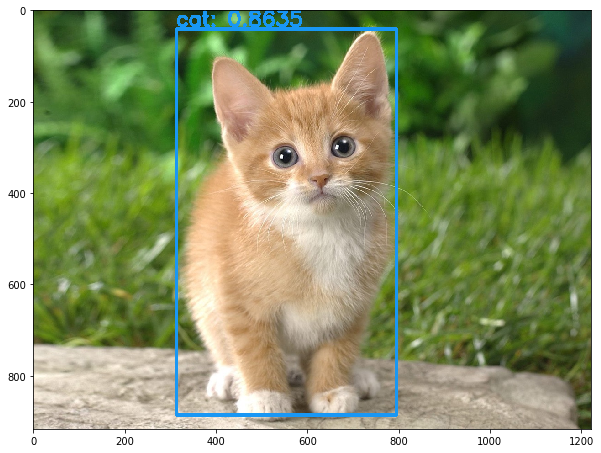

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()
